In [0]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import *
from imblearn.under_sampling import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df_complex2 = pd.read_csv('/content/drive/My Drive/[핀테크 과정] 머신러닝 팀플/기계학습 프로젝트/#data/complex_final.csv', na_values='n/a', index_col="SK_ID_CURR")

In [0]:
df_complex2

pc live2  ...  TARGET
SK_ID_CURR            ...        
100002      0.360469  ...       1
100003      1.000000  ...       0
100004      0.360469  ...       0
100006      0.360469  ...       0
100007      0.360469  ...       0
...              ...  ...     ...
456251      1.000000  ...       0
456252      0.360469  ...       0
456253      0.000000  ...       0
456254      0.360469  ...       1
456255      1.000000  ...       0

[304524 rows x 37 columns]

In [0]:
df_complex2.columns

Index(['pc live2', 'NAME_FAMILY_STATUS_Married', 'FLAG_WORK_PHONE',
       'EXT_SOURCE_3', 'EXT_SOURCE_2', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE', 'CREDIT_LENGTH',
       'CODE_GENDER_M', 'AMT_REQ_CREDIT_BUREAU_MON', 'pc loan1',
       'YEARS_BEGINEXPLUATATION_MODE', 'ORGANIZATION_TYPE_Self-employed',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'NAME_EDUCATION_TYPE_High', 'FLAG_PHONE',
       'FLAG_OWN_CAR_Y', 'CNT_FAM_MEMBERS', 'REG_CITY_NOT_LIVE_CITY',
       'REGION_POPULATION_RELATIVE', 'OWN_CAR_AGE', 'ORGANIZATION_TYPE_public',
       'ORGANIZATION_TYPE_School', 'ORGANIZATION_TYPE_Business',
       'OCCUPATION_TYPE_Middle', 'OCCUPATION_TYPE_Independent',
       'OCCUPATION_TYPE_High', 'NAME_TYPE_SUITE_Heart',
       'HOUR_APPR_PROCESS_START_PM', 'FLAG_DOCUMENT', 'DAYS_BIRTH_60s',
       'DAYS_BIRTH_50s', 'DAYS_BIRTH_30s', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'TARGET'],
      dtype='object')

In [0]:
X_df= df_complex2.iloc[:, :35]
y_df= df_complex2.TARGET

Metrics 함수정의

In [0]:
##혼동행렬
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False, cf_report=False,
                          title='Confusion matrix', ax=None, cmap=plt.cm.Blues, cbar=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    if cf_report:
        print(classification_report(y_true,y_pred))
    
    fig, ax = (plt.gcf(), ax) if ax is not None else plt.subplots(1,1)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    
    if cbar:
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04) # "Magic" numbers (https://stackoverflow.com/a/26720422/10939610)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

In [0]:
##ROC CURVE
def plot_roc(y_true, y_pred, ax=None):
    """Plot ROC curve""" 
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_true, y_pred)
    roc_score = roc_auc_score(y_true,y_pred)
    
    fig, ax = (plt.gcf(), ax) if ax is not None else plt.subplots(1,1)

    ax.set_title("Receiver Operating Characteristic")
    ax.plot(false_positive_rate, true_positive_rate)
    ax.plot([0, 1], ls="--")
    ax.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    ax.annotate('ROC: {:.5f}'.format(roc_score), [0.75,0.05])
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    fig.tight_layout()
    return roc_score

In [0]:
##혼동행렬 & ROC Curve
def plot_cmroc(y_true, y_pred, classes=[0,1], normalize=True, cf_report=False):
    """Convenience function to plot confusion matrix and ROC curve """
    fig,axes = plt.subplots(1,2, figsize=(9,4))
    plot_confusion_matrix(y_true, y_pred, classes=classes, normalize=normalize, cf_report=cf_report, ax=axes[0])
    roc_score = plot_roc(y_true, y_pred, ax=axes[1])
    fig.tight_layout()
    plt.show()
    return roc_score

In [0]:
##Feature Importance
def feat_imps(clf, X_train, plot=False, n=None):
    """ Dataframe containing each feature with its corresponding importance in the given model
    
    Args
    ----
        model : model, classifier that supports .feature_importances_ (RandomForest, AdaBoost, ect..)
        X_train : array like, training data object
        plot : boolean, if True, plots the data in the form of a bargraph
        n : int, only applicable if plot=True, number of features to plot, (default=15)
        
    Returns
    -------
        pandas DataFrame : columns = feature name, importance
    """
    
    fi_df = pd.DataFrame({'feature':X_train.columns,
                          'importance':clf.feature_importances_}
                        ).sort_values(by='importance', ascending=False)
    if plot:
        fi_df[:(n if n is not None else 15)].plot.bar(x='feature',y='importance')
    else:
        return fi_df

CV + Classifier evaluator 

In [0]:
def evaluate_classifier(clf, df_scores, X_df, y_df, clf_name=None):
    acc_list = []
    bal_acc_list = []
    auc_list = []
    recall_list = []
    f1_list = []
    fbeta_list = []    
    
    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
  
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 
    for train_index, test_index in kfold.split(X_df):
        X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
        y_train, y_test = y_df.iloc[train_index], y_df.iloc[test_index]
        X_train, X_test = X_train.values, X_test.values
        
        ###accuracy###
        acc = clf.fit(X_train, y_train).score(X_test, y_test)
        
        ###balanced accuracy###
        y_pred = clf.predict(X_test)
        bal_acc = balanced_accuracy_score(y_test, y_pred)

        ###AUC###
      
        if clf_name[0:2] in ('LR' , 'SV' , 'RF', 'XG', 'LG'):
              fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
        else:
              fpr, tpr, thresholds = roc_curve(y_test, clf.decision_function(X_test))
        aucs = auc(fpr, tpr) 

         ###Recall### 
        recall = recall_score(y_test, y_pred)

         ###F-1 Score###
        f1 = f1_score(y_test, y_pred)

        ###F-b Score###
        fbeta = fbeta_score(y_test, y_pred, 0.5)

        acc_list.append(acc)
        bal_acc_list.append(bal_acc)
        auc_list.append(aucs)
        recall_list.append(recall)
        f1_list.append(f1)
        fbeta_list.append(fbeta)   

    
    cv_acc = np.mean(acc_list)
    cv_bal_acc = np.mean(bal_acc_list)
    cv_auc = np.mean(auc_list)
    cv_recall = np.mean(recall_list)
    cv_f1 = np.mean(f1_list)
    cv_fb = np.mean(fbeta_list)
    
    clf_score = pd.DataFrame(
        {clf_name: [acc,bal_acc, aucs, recall, f1, fbeta]},
        index=['Accuracy', 'Balanced accuracy', 'AUC', 'Recall', 'F-1 score', 'F-beta Score']
    )  
    print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1']))
    print(fpr.round(decimals=2), tpr.round(decimals=2))
    #여기서는 상환능력있음이 0class를 가짐
    #위양성률(FPR) : 실제로는 1, 상환능력이 부족한 사람에게 상환할 수 있다고 판단한 비율
    df_scores = pd.concat([df_scores, clf_score], axis=1).round(decimals=3)
    return df_scores, X_train, y_test, y_pred, clf

In [0]:
df_scores = pd.DataFrame()

# 분류기 모델별/Sampling 방법별 적용

## 1.UnderSampling

In [0]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler

### 1-1. Random Under Sampling

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
    RandomUnderSampler(random_state=0),LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with RUS")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(

              precision    recall  f1-score   support

     class 0       0.95      0.67      0.79     55932
     class 1       0.15      0.64      0.24      4972

    accuracy                           0.67     60904
   macro avg       0.55      0.66      0.51     60904
weighted avg       0.89      0.67      0.74     60904

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LR with RUS
Accuracy                 0.668
Balanced accuracy        0.657
AUC                      0.719
Recall                   0.644
F-1 score                0.240
F-beta Score             0.175

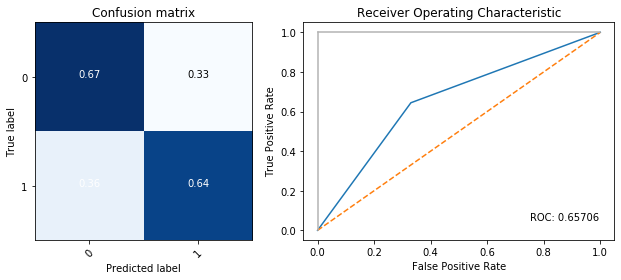

0.6570640901211556

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
    RandomUnderSampler(random_state=0),RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with RUS")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.96      0.69      0.80     55932
     class 1       0.16      0.65      0.25      4972

    accuracy                           0.68     60904
   macro avg       0.56      0.67      0.52     60904
weighted avg       0.89      0.68      0.75     60904

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.03 0.03 0.03 0.04 0.05 0.05
 0.06 0.07 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15 0.17 0.18 0.2
 0.21 0.23 0.24 0.26 0.28 0.29 0.31 0.33 0.35 0.37 0.39 0.41 0.43 0.45
 0.47 0.5  0.52 0.54 0.56 0.59 0.61 0.63 0.66 0.68 0.7  0.73 0.75 0.77
 0.79 0.81 0.83 0.85 0.87 0.89 0.9  0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.98 0.99 0.99 0.99 1.   1.   1.   1.   1.   1.   1.  ] [0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.01 0.02 0.02 0.03
 0.04 0.05 0.06 0.07 0.08 0.09 0.11 0.12 0.14 0.15 0.17 0.19 0.21 0.22
 0.24 0.26 0.28 0.3  0.32 0.34 0.37 0.39 0.41 0.43 

LR with RUS  RF with RUS
Accuracy                 0.668        0.683
Balanced accuracy        0.657        0.668
AUC                      0.719        0.729
Recall                   0.644        0.649
F-1 score                0.240        0.251
F-beta Score             0.175        0.183

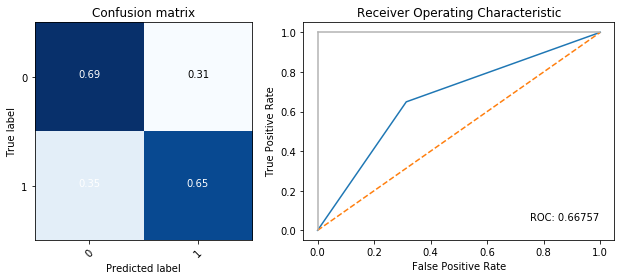

0.6675655572802488

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

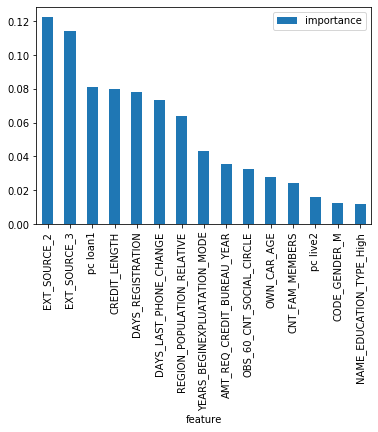

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
    RandomUnderSampler(random_state=0),SGDClassifier(penalty= 'l2', max_iter=1000, loss='log'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with RUS")
df_scores


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.96      0.51      0.66     55932
     class 1       0.12      0.78      0.21      4972

    accuracy                           0.53     60904
   macro avg       0.54      0.64      0.44     60904
weighted avg       0.89      0.53      0.63     60904

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LR with RUS  RF with RUS  SVM with RUS
Accuracy                 0.668        0.683         0.529
Balanced accuracy        0.657        0.668         0.644
AUC                      0.719        0.729         0.715
Recall                   0.644        0.649         0.782
F-1 score                0.240        0.251         0.213
F-beta Score             0.175        0.183         0.148

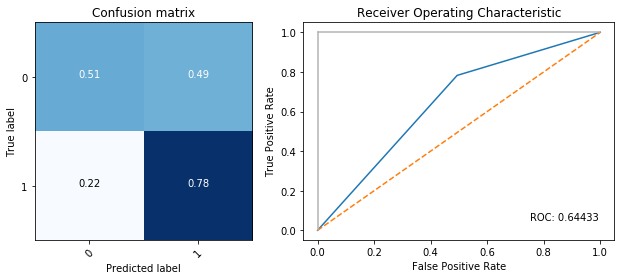

0.6443284064220264

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
    RandomUnderSampler(random_state=0),XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with RUS")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.96      0.68      0.80     55932
     class 1       0.16      0.67      0.26      4972

    accuracy                           0.68     60904
   macro avg       0.56      0.68      0.53     60904
weighted avg       0.89      0.68      0.75     60904

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LR with RUS  RF with RUS  SVM with RUS  XGB with RUS
Accuracy                 0.668        0.683         0.529         0.682
Balanced accuracy        0.657        0.668         0.644         0.676
AUC                      0.719        0.729         0.715         0.740
Recall                   0.644        0.649         0.782         0.669
F-1 score                0.240        0.251         0.213         0.256
F-beta Score             0.175        0.183         0.148         0.186

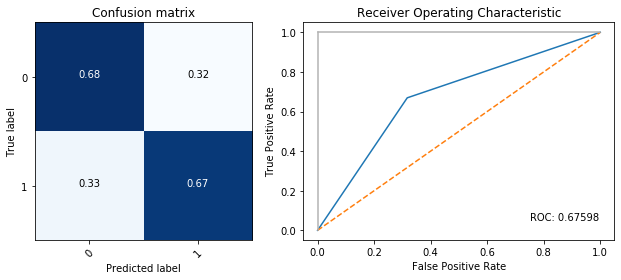

0.6759792476429113

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

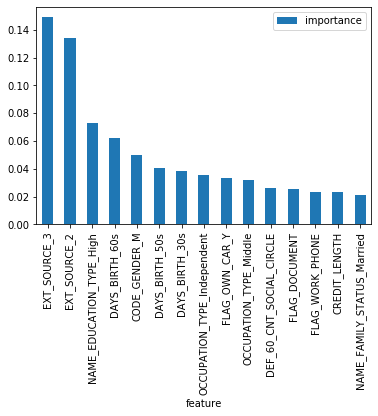

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
 RandomUnderSampler(random_state=0),LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with RUS")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


KeyboardInterrupt: ignored

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

## ----------------------------------------------------------------------------

### 1-2. TomekLinks

In [0]:
#tl = TomekLinks(return_indices=True, ratio='majority',sampling_strategy=0.8)
tl = TomekLinks()

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
    tl ,LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with Tomek")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(

              precision    recall  f1-score   support

     class 0       0.92      1.00      0.96     55932
     class 1       0.39      0.00      0.01      4972

    accuracy                           0.92     60904
   macro avg       0.65      0.50      0.48     60904
weighted avg       0.88      0.92      0.88     60904

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LR with Tomek
Accuracy                   0.918
Balanced accuracy          0.501
AUC                        0.719
Recall                     0.003
F-1 score                  0.006
F-beta Score               0.016

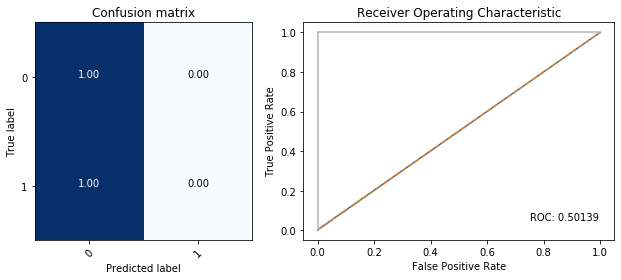

0.501385524797408

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
    tl,RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with Tomek")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.92      1.00      0.96     55932
     class 1       0.57      0.01      0.01      4972

    accuracy                           0.92     60904
   macro avg       0.74      0.50      0.48     60904
weighted avg       0.89      0.92      0.88     60904

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.02 0.02 0.02 0.03 0.03 0.04 0.04 0.05 0.06 0.07 0.08 0.09
 0.1  0.12 0.13 0.15 0.18 0.2  0.23 0.27 0.31 0.35 0.4  0.46 0.52 0.59
 0.67 0.76 0.84 0.92 0.97 1.  ] [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.01 0.01
 0.01 0.01 0.02 0.02 0.02 0.03 0.03 0.03 0.04 0.04 0.05 0.06 0.06 0.07
 0.08 0.09 0.1  0.11 0.13 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.29 0.31
 0.34 0.37 0.4  0.43 0.47 0.5  0.54 0.58 0.62 0.66 0.7  0.75 0.79 0.84
 0.88 0.92 0.95 0.98 0.99 1.  ]


LR with Tomek  RF with Tomek
Accuracy                   0.918          0.918
Balanced accuracy          0.501          0.502
AUC                        0.719          0.710
Recall                     0.003          0.005
F-1 score                  0.006          0.010
F-beta Score               0.016          0.025

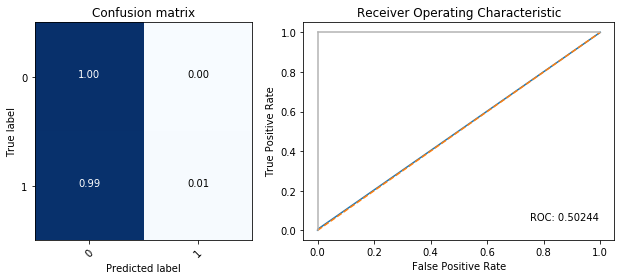

0.5024358534662449

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

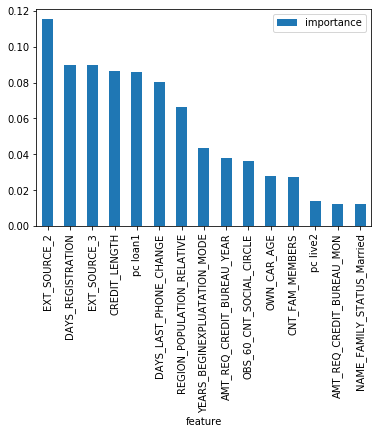

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
    tl,SGDClassifier(penalty= 'l2', max_iter=1000, loss='hinge'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with Tomek")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
#feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
    tl,XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with Tomek")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.92      1.00      0.96     55932
     class 1       0.50      0.00      0.01      4972

    accuracy                           0.92     60904
   macro avg       0.71      0.50      0.48     60904
weighted avg       0.88      0.92      0.88     60904

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


XGB with Tomek
Accuracy                    0.918
Balanced accuracy           0.502
AUC                         0.740
Recall                      0.004
F-1 score                   0.007
F-beta Score                0.018

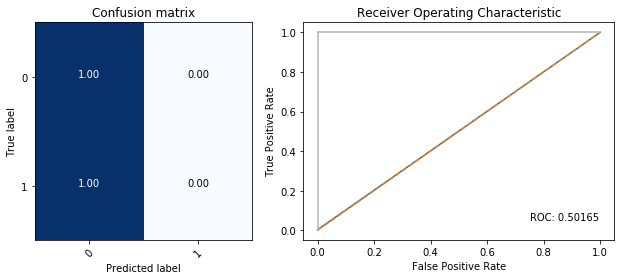

0.5016492270898538

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

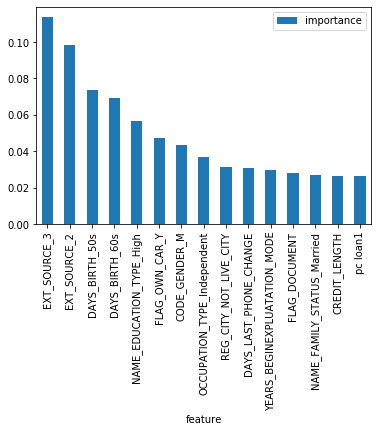

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
 tl,LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with Tomek")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.92      0.99      0.96     55932
     class 1       0.38      0.04      0.08      4972

    accuracy                           0.92     60904
   macro avg       0.65      0.52      0.52     60904
weighted avg       0.88      0.92      0.88     60904

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


XGB with Tomek  LGBM with Tomek
Accuracy                    0.918            0.916
Balanced accuracy           0.502            0.519
AUC                         0.740            0.719
Recall                      0.004            0.044
F-1 score                   0.007            0.078
F-beta Score                0.018            0.150

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

## ----------------------------------------------------------------------------

### 1-3. OneSidedSelection(Tomek+CNN)

In [0]:
os = OneSidedSelection(random_state=0)

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
    os ,LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with OSS")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
    os,RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with OSS")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
    os,SGDClassifier(penalty= 'l2', max_iter=1000, loss='log'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with OSS")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
   os,XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with OSS")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
 os,LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with OSS")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

## ----------------------------------------------------------------------------

### 1-4. Neighbourhood Cleaning Rule

In [0]:
ncr = NeighbourhoodCleaningRule(kind_sel="all", n_neighbors=5, random_state=0)

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
    ncr ,LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with NCR")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
    ncr,RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with NCR")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
    ncr,SGDClassifier(penalty= 'l2', max_iter=1000, loss='log'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with NCR")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
   ncr,XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with NCR")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
 ncr,LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with NCR")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

## ----------------------------------------------------------------------------

### 1-5. EditedNearestNeighbours

In [0]:
ENN = EditedNearestNeighbours(kind_sel="all", n_neighbors=5, random_state=0)

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
    ENN ,LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with ENN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
    ENN,RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with ENN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
    ENN,SGDClassifier(penalty= 'l2', max_iter=1000, loss='log'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with ENN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
   ENN,XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with ENN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
 ENN,LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with ENN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

## ----------------------------------------------------------------------------

## 2. Oversampling

In [0]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

### 2-1. Random Over Sampler

In [0]:
ROS = RandomOverSampler(random_state=0,sampling_strategy=0.8)

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
   ROS ,LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with ROS")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(

              precision    recall  f1-score   support

     class 0       0.95      0.76      0.84     55932
     class 1       0.17      0.55      0.26      4972

    accuracy                           0.74     60904
   macro avg       0.56      0.65      0.55     60904
weighted avg       0.89      0.74      0.79     60904

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LR with ROS
Accuracy                 0.740
Balanced accuracy        0.653
AUC                      0.719
Recall                   0.549
F-1 score                0.256
F-beta Score             0.194

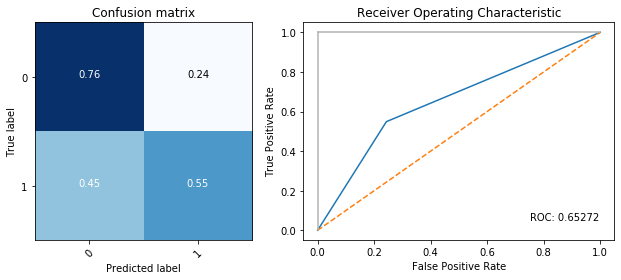

0.6527176158453298

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
    ROS,RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with ROS")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.92      1.00      0.96     55932
     class 1       0.44      0.02      0.04      4972

    accuracy                           0.92     60904
   macro avg       0.68      0.51      0.50     60904
weighted avg       0.88      0.92      0.88     60904

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.03 0.03 0.03 0.04
 0.04 0.05 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.14 0.16 0.18 0.2
 0.23 0.26 0.3  0.33 0.37 0.42 0.47 0.52 0.58 0.64 0.71 0.78 0.85 0.91
 0.96 0.99 1.  ] [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01
 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.04 0.04
 0.05 0.05 0.06 0.07 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.15 0.16 0.18
 0.2  0.21 0.23 0.25 0.28 0.29 0.31 0.34 0.37 0.39 0.42 0.45 0.48 0.51
 0.55 0.58 0.62 0.66

LR with ROS  RF with ROS
Accuracy                 0.740        0.918
Balanced accuracy        0.653        0.509
AUC                      0.719        0.721
Recall                   0.549        0.020
F-1 score                0.256        0.038
F-beta Score             0.194        0.085

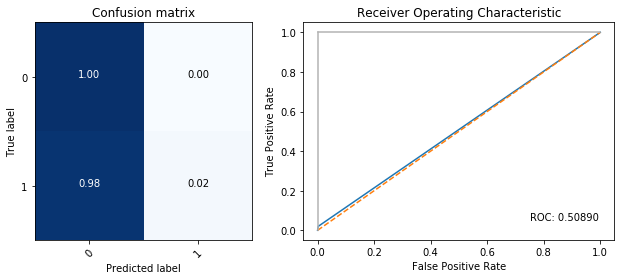

0.5089031293544645

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

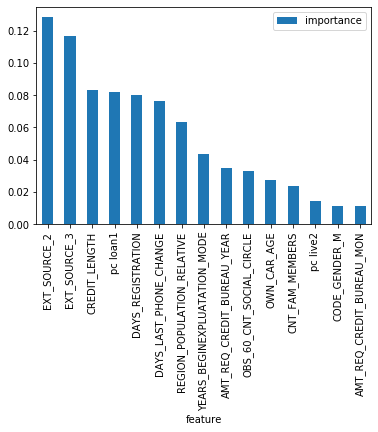

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
    ROS,SGDClassifier(penalty= 'l2', max_iter=1000, loss='log'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with ROS")
df_scores



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.95      0.78      0.86     55932
     class 1       0.17      0.51      0.26      4972

    accuracy                           0.76     60904
   macro avg       0.56      0.65      0.56     60904
weighted avg       0.88      0.76      0.81     60904

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LR with ROS  RF with ROS  SVM with ROS
Accuracy                 0.740        0.918         0.761
Balanced accuracy        0.653        0.509         0.648
AUC                      0.719        0.721         0.719
Recall                   0.549        0.020         0.513
F-1 score                0.256        0.038         0.260
F-beta Score             0.194        0.085         0.200

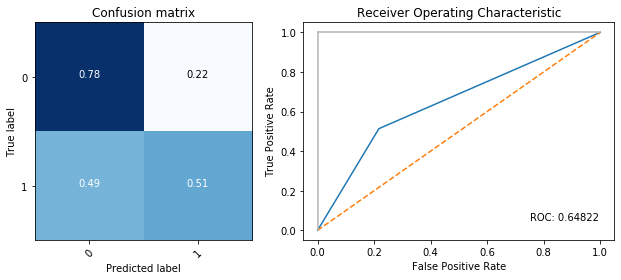

0.6482198041996634

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

AttributeError: ignored

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
   ROS,XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with ROS")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.95      0.77      0.85     55932
     class 1       0.18      0.58      0.28      4972

    accuracy                           0.75     60904
   macro avg       0.57      0.67      0.56     60904
weighted avg       0.89      0.75      0.80     60904

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LR with ROS  RF with ROS  SVM with ROS  XGB with ROS
Accuracy                 0.740        0.918         0.761         0.751
Balanced accuracy        0.653        0.509         0.648         0.674
AUC                      0.719        0.721         0.719         0.742
Recall                   0.549        0.020         0.513         0.583
F-1 score                0.256        0.038         0.260         0.277
F-beta Score             0.194        0.085         0.200         0.210

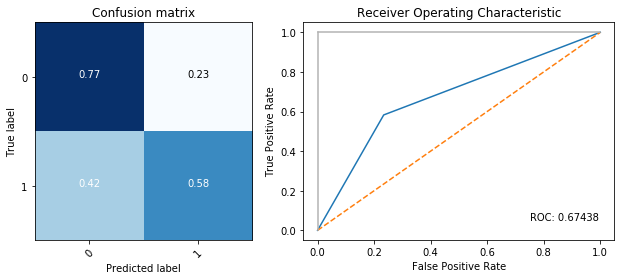

0.6743769399562243

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

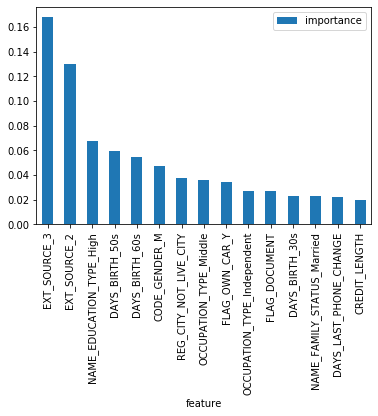

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
ROS,LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with ROS")
df_scores



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.93      0.93      0.93     55932
     class 1       0.24      0.26      0.25      4972

    accuracy                           0.87     60904
   macro avg       0.59      0.59      0.59     60904
weighted avg       0.88      0.87      0.87     60904

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LR with ROS  RF with ROS  ...  XGB with ROS  LGBM with ROS
Accuracy                 0.740        0.918  ...         0.751          0.872
Balanced accuracy        0.653        0.509  ...         0.674          0.595
AUC                      0.719        0.721  ...         0.742          0.705
Recall                   0.549        0.020  ...         0.583          0.263
F-1 score                0.256        0.038  ...         0.277          0.252
F-beta Score             0.194        0.085  ...         0.210          0.245

[6 rows x 5 columns]

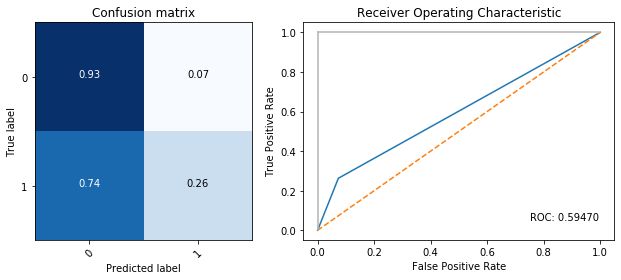

0.5947039385660176

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

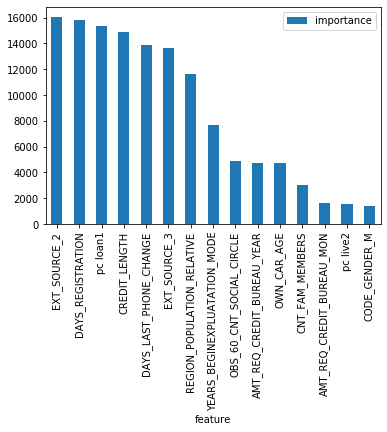

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

## ----------------------------------------------------------------------------

### 2-2. SMOTE

In [0]:
SMOTE = SMOTE(ratio='minority',random_state=0,sampling_strategy=0.8)

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
   SMOTE ,LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with SMOTE")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(

              precision    recall  f1-score   support

     class 0       0.95      0.67      0.79     55932
     class 1       0.15      0.64      0.24      4972

    accuracy                           0.67     60904
   macro avg       0.55      0.66      0.52     60904
weighted avg       0.89      0.67      0.74     60904

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LR with ROS  RF with ROS  ...  LGBM with ROS  LR with SMOTE
Accuracy                 0.740        0.918  ...          0.872          0.670
Balanced accuracy        0.653        0.509  ...          0.595          0.657
AUC                      0.719        0.721  ...          0.705          0.718
Recall                   0.549        0.020  ...          0.263          0.640
F-1 score                0.256        0.038  ...          0.252          0.241
F-beta Score             0.194        0.085  ...          0.245          0.175

[6 rows x 6 columns]

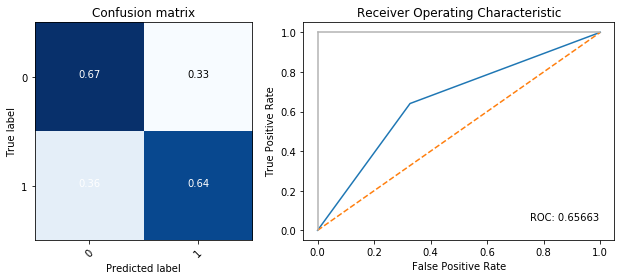

0.6566283955652621

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
    SMOTE,RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with SMOTE")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.92      0.99      0.96     55932
     class 1       0.33      0.04      0.07      4972

    accuracy                           0.92     60904
   macro avg       0.63      0.52      0.51     60904
weighted avg       0.87      0.92      0.88     60904

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.04
 0.04 0.05 0.05 0.06 0.07 0.08 0.08 0.09 0.1  0.12 0.13 0.14 0.16 0.18
 0.2  0.22 0.24 0.26 0.29 0.32 0.35 0.38 0.42 0.46 0.5  0.54 0.58 0.63
 0.68 0.73 0.78 0.83 0.87 0.92 0.95 0.98 0.99 1.  ] [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.04
 0.04 0.04 0.05 0.06 0.06 0.07 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.15
 0.16 0.18 0.2  0.21 0.23 0.24 0.27 0.29 0.31 0.34 0.36 0

LR with ROS  RF with ROS  ...  LR with SMOTE  RF with SMOTE
Accuracy                 0.740        0.918  ...          0.670          0.915
Balanced accuracy        0.653        0.509  ...          0.657          0.516
AUC                      0.719        0.721  ...          0.718          0.703
Recall                   0.549        0.020  ...          0.640          0.039
F-1 score                0.256        0.038  ...          0.241          0.070
F-beta Score             0.194        0.085  ...          0.175          0.133

[6 rows x 7 columns]

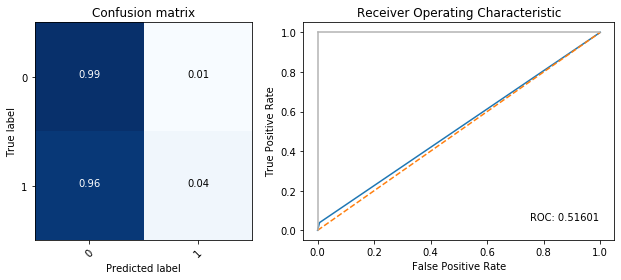

0.5160139360695947

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

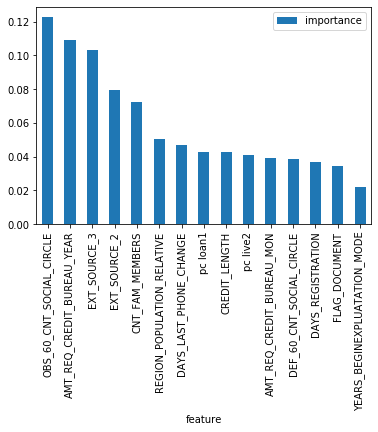

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
    SMOTE,SGDClassifier(penalty= 'l2', max_iter=1000, loss='log'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with SMOTE")
df_scores


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.96      0.66      0.78     55932
     class 1       0.15      0.66      0.24      4972

    accuracy                           0.66     60904
   macro avg       0.55      0.66      0.51     60904
weighted avg       0.89      0.66      0.74     60904

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LR with ROS  RF with ROS  ...  RF with SMOTE  SVM with SMOTE
Accuracy                 0.740        0.918  ...          0.915           0.659
Balanced accuracy        0.653        0.509  ...          0.516           0.658
AUC                      0.719        0.721  ...          0.703           0.718
Recall                   0.549        0.020  ...          0.039           0.657
F-1 score                0.256        0.038  ...          0.070           0.239
F-beta Score             0.194        0.085  ...          0.133           0.173

[6 rows x 8 columns]

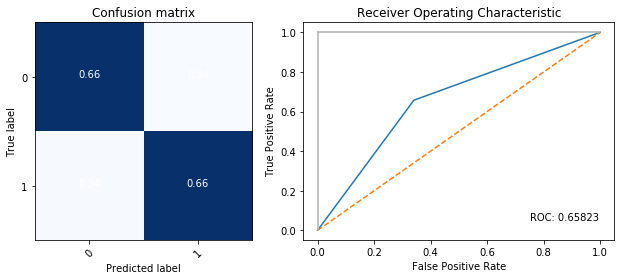

0.6582258703520519

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

AttributeError: ignored

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
  SMOTE,XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with SMOTE")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.92      0.99      0.96     55932
     class 1       0.31      0.04      0.06      4972

    accuracy                           0.91     60904
   macro avg       0.61      0.51      0.51     60904
weighted avg       0.87      0.91      0.88     60904

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LR with ROS  RF with ROS  ...  SVM with SMOTE  XGB with SMOTE
Accuracy                 0.740        0.918  ...           0.659           0.915
Balanced accuracy        0.653        0.509  ...           0.658           0.514
AUC                      0.719        0.721  ...           0.718           0.701
Recall                   0.549        0.020  ...           0.657           0.035
F-1 score                0.256        0.038  ...           0.239           0.063
F-beta Score             0.194        0.085  ...           0.173           0.121

[6 rows x 9 columns]

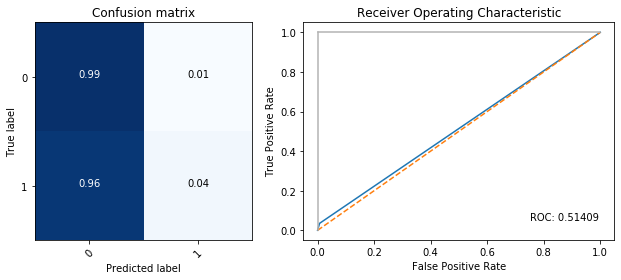

0.5140853572971523

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

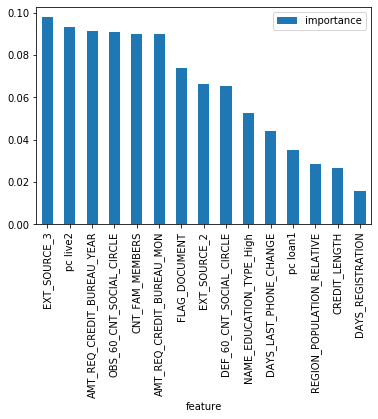

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
SMOTE,LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with SMOTE")
df_scores


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

              precision    recall  f1-score   support

     class 0       0.92      1.00      0.96     55932
     class 1       0.42      0.04      0.07      4972

    accuracy                           0.92     60904
   macro avg       0.67      0.52      0.51     60904
weighted avg       0.88      0.92      0.88     60904

[0. 0. 0. ... 1. 1. 1.] [0. 0. 0. ... 1. 1. 1.]


LGBM with SMOTE
Accuracy                     0.917
Balanced accuracy            0.517
AUC                          0.718
Recall                       0.039
F-1 score                    0.071
F-beta Score                 0.142

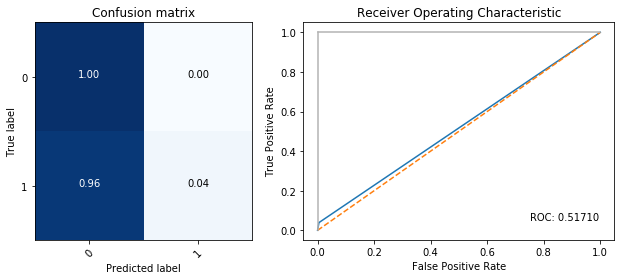

0.517095606669609

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

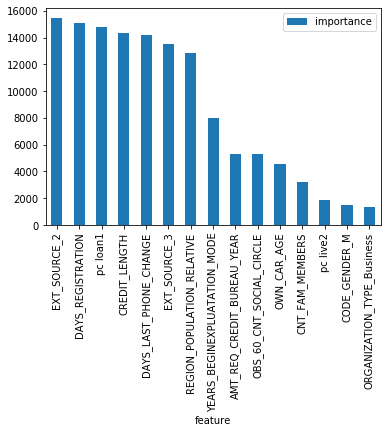

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

### 2-3. ADASYN

In [0]:
ADASYN= ADASYN(random_state=0,sampling_strategy=0.8).fit_sample(X_df, y_df)

TypeError: ignored

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
  ADASYN ,LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with ADASYN")
df_scores

TypeError: ignored

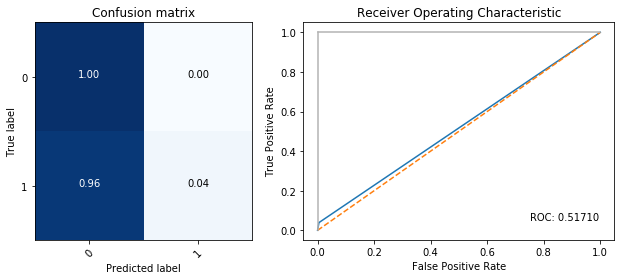

0.517095606669609

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
   ADASYN,RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with ADASYN")
df_scores

TypeError: ignored

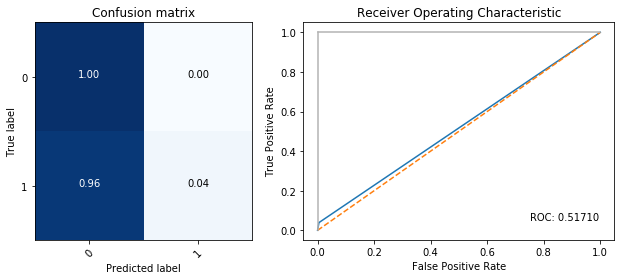

0.517095606669609

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

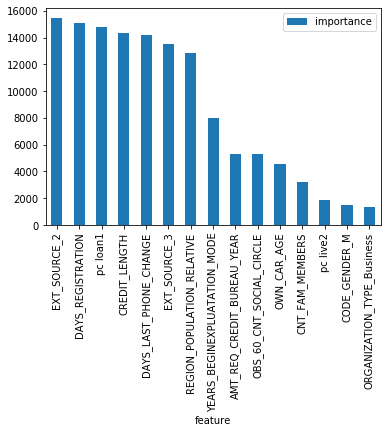

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
    ADASYN,SGDClassifier(penalty= 'l2', max_iter=1000, loss='log'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with ADASYN")
df_scores



TypeError: ignored

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
  ADASYN,XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with ADASYN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
ADASYN,LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with ADASYN")
df_scores


In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

## ----------------------------------------------------------------------------

## 3. 복합 Sampling

In [0]:
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import *

### 3-1. SMOTETomek

In [0]:
smt = SMOTETomek(ratio='auto',random_state=0,sampling_strategy=0.8)

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
 smt ,LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with SMOTE + Tomek links")
df_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
    smt,RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with SMOTE + Tomek links")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
    smt,SGDClassifier(penalty= 'l2', max_iter=1000, loss='log'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with SMOTE + Tomek links")
df_scores



In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
  smt,XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with SMOTE + Tomek links")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
smt,LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with SMOTE + Tomek links")
df_scores



In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

### 3-2. SMOTEENN

In [0]:
sme = SMOTEENN(random_state=0,sampling_strategy=0.8).fit_sample(X_df, y_df)

In [0]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = make_pipeline_with_sampler(
 sme ,LogisticRegression())
df_scores, X_train, y_test, y_pred, clf= evaluate_classifier(lr_clf, df_scores, X_df, y_df, "LR with SMOTE + ENN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = make_pipeline_with_sampler(
   sme,RandomForestClassifier(random_state=42, n_jobs=2))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(rf_clf, df_scores, X_df, y_df, "RF with SMOTE + ENN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#SVM
from sklearn.linear_model import SGDClassifier
svm_clf = make_pipeline_with_sampler(
 sme,SGDClassifier(penalty= 'l2', max_iter=1000, loss='log'))
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(svm_clf, df_scores, X_df, y_df, "SVM with SMOTE + ENN")
df_scores



In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#XGB
from xgboost import XGBClassifier
xgb_clf = make_pipeline_with_sampler(
  sme,XGBClassifier()
)
df_scores, X_train, y_test, y_pred, clf  = evaluate_classifier(xgb_clf, df_scores,  X_df, y_df, "XGB with SMOTE + ENN")
df_scores

In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

In [0]:
#LGBM
from lightgbm import LGBMClassifier
lgbm_clf = make_pipeline_with_sampler(
sme,LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
)
df_scores, X_train, y_test, y_pred, clf = evaluate_classifier(lgbm_clf, df_scores, X_df, y_df,"LGBM with SMOTE + ENN")
df_scores



In [0]:
#option : CM & ROC
plot_cmroc(y_test, y_pred)

In [0]:
#option2 :  feature Importance
feat_imps(clf.steps[1][1], X_df, plot=True)

모델 fine-tuning, hyperparameter 찾기

In [0]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42) # cross-validation 
for train_index, test_index in kfold.split(X_df):
    X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    y_train, y_test = y_df.iloc[train_index], y_df.iloc[test_index]
    X_train, X_test = X_train.values, X_test.values

## 1. GridSearch


In [0]:
#RF
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]


forest = RandomForestClassifier(random_state=42) #randomforest 선택
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest, param_grid, cv=5,
                           scoring='roc_auc',
                           return_train_score=True) #cv를 하면서 gridsearch
acc = grid_search.fit(X_train, y_train).score(X_test, y_test)
y_pred = grid_search.predict(X_test)
bal_acc = balanced_accuracy_score(y_test, y_pred)

In [0]:
grid_search.best_params_
grid_search.best_score_

In [0]:
#XGB

param_grid = {
        'n_estimators' : [100, 200, 400, 600],
          'learning_rate' : [0.01,0.05,0.1,0.15,0.2],
          'max_depth' : [4,6,8,10,12]
}

XGB_grid = XGBClassifier(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(XGB_grid, param_grid, cv=5,
                           scoring='roc_auc',
                           return_train_score=True) #cv를 하면서 gridsearch
acc = grid_search.fit(X_train, y_train).score(X_test, y_test)
y_pred = grid_search.predict(X_test)
bal_acc = balanced_accuracy_score(y_test, y_pred)

recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fbeta = fbeta_score(y_test, y_pred, 0.5)
print(acc, bal_acc,recall, f1, fbeta)

In [0]:
grid_search.best_params_
grid_search.best_score_

In [0]:
#LGBM


param_grid = {
        'n_estimators' : [100, 200, 400, 600],
          'learning_rate' : [0.01,0.05,0.1,0.15,0.2],
          'max_depth' : [4,6,8,10,12]
}


LGBM_grid = LGBMClassifier(random_state=42) 
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(LGBM_grid, param_grid, cv=5,
                           scoring='roc_auc',
                           return_train_score=True) #cv를 하면서 gridsearch
acc = grid_search.fit(X_train, y_train).score(X_test, y_test)
y_pred = grid_search.predict(X_test)
bal_acc = balanced_accuracy_score(y_test, y_pred)

recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fbeta = fbeta_score(y_test, y_pred, 0.5)
print(acc, bal_acc,recall, f1, fbeta)

In [0]:
grid_search.best_params_
grid_search.best_score_

## 2. RandomSearch


In [0]:
##RandomizedSearch
#RF
#다찾지 않고 random값 iterate하면서 찾기
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200), #1~200 사이 random 값
        'max_features': randint(low=1, high=8), #1~8 사이 random 값
    }

forest = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(forest, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='roc_auc', random_state=42) #10번 iterate, cross validation 5
acc = rnd_search.fit(X_train, y_train).score(X_test, y_test)
y_pred = rnd_search.predict(X_test)
bal_acc = balanced_accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fbeta = fbeta_score(y_test, y_pred, 0.5)
print(acc, bal_acc,recall, f1, fbeta)

In [0]:
rnd_search.best_params_
rnd_search.best_score_

In [0]:
#XGB
param_distribs = {
        'n_estimators': randint(low=1, high=200), #1~200 사이 random 값
         'learning_rate' : randint(low=0.01, high=0.2), #1~8 사이 random 값
       'max_depth' : randint(low=4, high=12)
    }

XGB= XGBClassifier()
rnd_search = RandomizedSearchCV(XGB, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='roc_auc', random_state=42) #10번 iterate, cross validation 5
acc = rnd_search.fit(X_train, y_train).score(X_test, y_test)
y_pred = rnd_search.predict(X_test)
bal_acc = balanced_accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fbeta = fbeta_score(y_test, y_pred, 0.5)
print(acc, bal_acc,recall, f1, fbeta)

In [0]:
rnd_search.best_params_
rnd_search.best_score_

In [0]:
#LGBM
param_distribs = {
        'n_estimators': randint(low=1, high=200), #1~200 사이 random 값
         'learning_rate' : randint(low=0.01, high=0.2), #1~8 사이 random 값
       'max_depth' : randint(low=4, high=12)
    }


LGBM= LGBMClassifier(random_state=42) 
rnd_search = RandomizedSearchCV(LGBM, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='roc_auc', random_state=42) #10번 iterate, cross validation 5
acc = rnd_search.fit(X_train, y_train).score(X_test, y_test)
y_pred = rnd_search.predict(X_test)
bal_acc = balanced_accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fbeta = fbeta_score(y_test, y_pred, 0.5)
print(acc, bal_acc,recall, f1, fbeta)

In [0]:
rnd_search.best_params_
rnd_search.best_score_

------------------------------------------------

In [0]:
import sklearn
sklearn.metrics.SCORERS.keys()

# -----------------------------------------------------------------

# hyper parameter

In [0]:
import pandas as pd

In [0]:
df_complex = pd.read_csv('/content/drive/My Drive/[핀테크 과정] 머신러닝 팀플/기계학습 프로젝트/#data/complex_final.csv')

In [0]:
X= df_complex.drop(['TARGET'], axis=1)
y= df_complex.TARGET

In [7]:
from imblearn.under_sampling import *

#Data Sampling-1
X, y = RandomUnderSampler(random_state=0, sampling_strategy=0.8).fit_sample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


XGBOOST Optimization

In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [9]:
df_complex['TARGET'].values

array([1, 0, 0, ..., 0, 1, 0])

In [0]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.steps[1][1].get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.steps[1][1].get_params()['n_estimators'], nfold=cv_folds,
            metrics='aucpr', early_stopping_rounds=early_stopping_rounds)
        alg.steps[1][1].set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['TARGET'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors].values)
    dtrain_predprob = alg.predict_proba(dtrain[predictors].values)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['TARGET'].values, dtrain_predictions))
    print ("Balanced Accuracy : %.4g" % metrics.balanced_accuracy_score(dtrain['TARGET'].values, dtrain_predictions))
    print ("AUC Score : %f" % metrics.roc_auc_score(dtrain['TARGET'], dtrain_predprob))
    print ("Recall Score : %f" % metrics.recall_score(dtrain['TARGET'].values, dtrain_predictions))
    print ("F1 Score : %f" % metrics.f1_score(dtrain['TARGET'].values, dtrain_predictions))
    print ("Fbeta Score : %f" % metrics.fbeta_score(dtrain['TARGET'].values, dtrain_predictions, 0.2))
          
    #feat_imp = alg.feature_importances_
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')
    return alg, alg.steps[1][1], dtrain['TARGET'].values, dtrain_predictions, dtrain_predprob

In [0]:
target = 'TARGET'
IDcol = 'SK_ID_CURR'

In [0]:
predictors = [x for x in df_complex.columns if x not in [target, IDcol]]

In [0]:
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler

In [0]:
xgb1 = make_pipeline_with_sampler(
    RandomUnderSampler(random_state=42, sampling_strategy=0.8),XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
)

In [15]:
alg, alg2 ,  y_test, y_pred, y_prob = modelfit(xgb1, df_complex, predictors)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)



Model Report
Accuracy : 0.7533
Balanced Accuracy : 0.7044
AUC Score : 0.783727
Recall Score : 0.646072
F1 Score : 0.297852
Fbeta Score : 0.198897


In [16]:
xgb1.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('randomundersampler',
                 RandomUnderSampler(random_state=42, ratio=None,
                                    replacement=False, return_indices=False,
                                    sampling_strategy=0.8)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=None,
                               n_estimators=220, n_jobs=1, nthread=4,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=27, silent=None, subsample=0.8,
                            

In [0]:
import seaborn as sns
def feature_importance_df_(feature_importances_):
  feature_importance_df = pd.DataFrame()
  fold_importance_df = pd.DataFrame()
  fold_importance_df["feature"] = predictors
  fold_importance_df["importance"] = feature_importances_
  feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
  return feature_importance_df
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Feature importance')
    plt.tight_layout()

In [0]:
feature_importance_df_ = feature_importance_df_(alg2.feature_importances_)

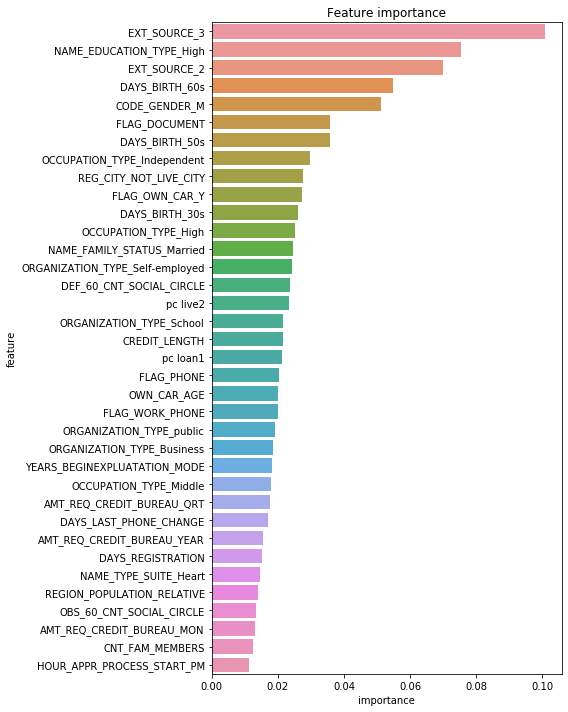

In [19]:
display_importances(feature_importance_df_ ) #under

In [0]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
import itertools

In [0]:
##혼동행렬
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False, cf_report=False,
                          title='Confusion matrix', ax=None, cmap=plt.cm.Blues, cbar=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    if cf_report:
        print(classification_report(y_true,y_pred))
    
    fig, ax = (plt.gcf(), ax) if ax is not None else plt.subplots(1,1)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    
    if cbar:
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04) # "Magic" numbers (https://stackoverflow.com/a/26720422/10939610)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

##ROC CURVE
def plot_roc(y_true, y_pred, ax=None):
    """Plot ROC curve""" 
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true,y_prob)
    
    fig, ax = (plt.gcf(), ax) if ax is not None else plt.subplots(1,1)

    ax.set_title("Receiver Operating Characteristic")
    ax.plot(false_positive_rate, true_positive_rate)
    ax.plot([0, 1], ls="--")
    ax.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    ax.annotate('AUC: {:.5f}'.format(auc_score), [0.75,0.05])
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    fig.tight_layout()
    return auc_score

##혼동행렬 & ROC Curve
def plot_cmroc(y_true, y_pred, y_prob,classes=[0,1], normalize=True, cf_report=False):
    """Convenience function to plot confusion matrix and ROC curve """
    fig,axes = plt.subplots(1,2, figsize=(9,4))
    plot_confusion_matrix(y_true, y_pred, classes=classes, normalize=normalize, cf_report=cf_report, ax=axes[0])
    auc_score = plot_roc(y_true, y_prob, ax=axes[1])
    fig.tight_layout()
    plt.show()
    return auc_score

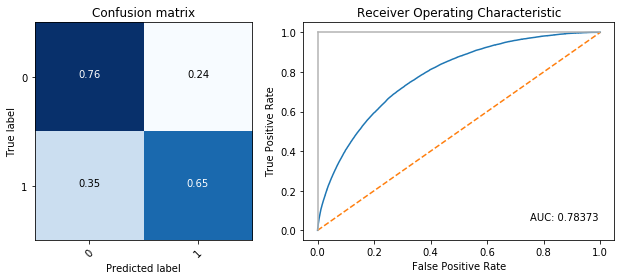

0.7837273166439216

In [22]:
plot_cmroc(y_test, y_pred, y_prob)